In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline

In [25]:
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
data=pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/datasets/Telefonia_movil.csv',thousands='.')
data['quarter'] = data['Año'].astype(str)+'Q'+data['Trimestre'].astype(str)
data['quarter'] = pd.to_datetime(data['quarter'])
data.index = data.quarter
data.index = data.index.to_period(freq='Q')
data = data[['Minutos pospago salientes (miles)','Minutos prepago salientes (miles)']]
data = data.rename(columns={'Minutos pospago salientes (miles)':'pospago',
                            'Minutos prepago salientes (miles)':'prepago'})


In [5]:
y_pospago = data.pospago
y_prepago = data.prepago

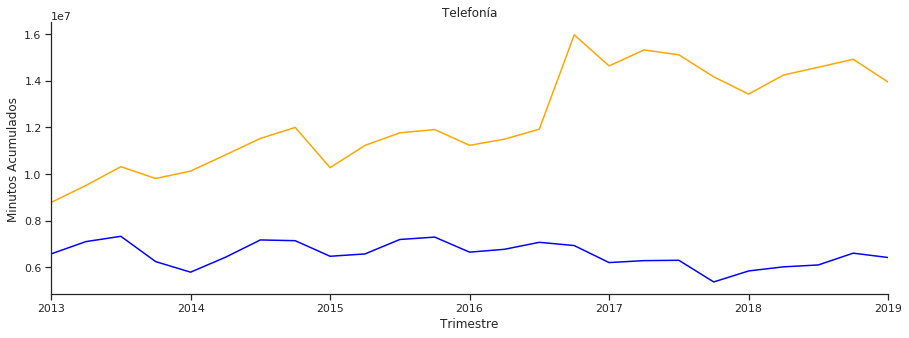

In [37]:
fig, ax= plt.subplots();#figsize=(9,6))
y_pospago.plot(color='orange')
y_prepago.plot(color='blue')
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Telefonía')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [7]:
display(y_pospago.describe().round(2))
display(y_prepago.describe().round(2))

count          25.00
mean     12359295.44
std       2085582.33
min       8785943.00
25%      10821463.00
50%      11905073.00
75%      14240217.00
max      15960765.00
Name: pospago, dtype: float64

count         25.0
mean     6562909.4
std       516860.4
min      5380710.0
25%      6250549.0
50%      6579819.0
75%      7077838.0
max      7335154.0
Name: prepago, dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [8]:
h = 4
test_pospago=pd.period_range(start=y_pospago.index[-1]+1, periods=h, freq='Q')
pred_pospago=pd.Series(np.repeat(y_pospago.iloc[-1], h), index=test_pospago) # the forecast repeats the last observed values h times
pred_pospago

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

In [9]:
h = 4
test_prepago=pd.period_range(start=y_prepago.index[-1]+1, periods=h, freq='Q')
pred_prepago=pd.Series(np.repeat(y_prepago.iloc[-1], h), index=test_prepago) # the forecast repeats the last observed values h times
pred_prepago

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

In [10]:
resid_pospago = y_pospago-y_pospago.shift(1) # the shift lags the series by one period
sigma_pospago = resid_pospago.std()

resid_prepago = y_prepago-y_prepago.shift(1) # the shift lags the series by one period
sigma_prepago = resid_prepago.std()

print(round(sigma_pospago,3),round(sigma_prepago,3))


1111026.926 510832.977


In [11]:
intv_pospago = pd.concat([pred_pospago-stats.norm.ppf(0.975)*sigma_pospago*np.sqrt(np.arange(1,h+1)),
                   pred_pospago+stats.norm.ppf(0.975)*sigma_pospago*np.sqrt(np.arange(1,h+1))], axis=1)

intv_prepago = pd.concat([pred_prepago-stats.norm.ppf(0.975)*sigma_prepago*np.sqrt(np.arange(1,h+1)),
                   pred_prepago+stats.norm.ppf(0.975)*sigma_prepago*np.sqrt(np.arange(1,h+1))], axis=1)

display(intv_pospago.round(3))
display(intv_prepago.round(3))

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


In [12]:
y_pospago.index.min()

Period('2013Q1', 'Q-DEC')

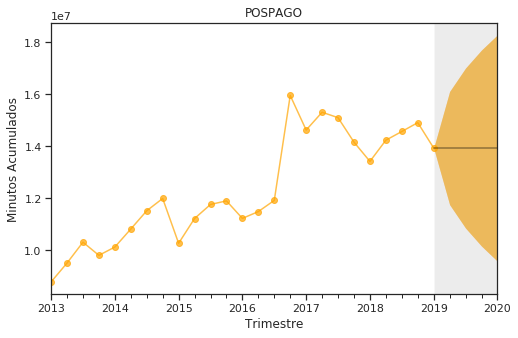

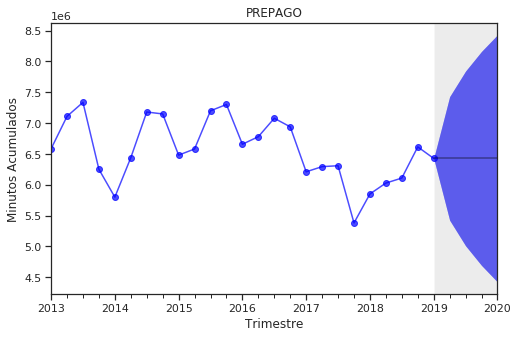

In [13]:
from plotting import fanchart
point_pred_pospago = (intv_pospago[0]+intv_pospago[1])/2
fig, ax = fanchart(y_pospago['2013':],point_pred_pospago,intv_pospago,intv_pospago,intv_pospago,'orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('POSPAGO')
point_pred_prepago = (intv_prepago[0]+intv_prepago[1])/2
ax.ticklabel_format(style='sci',axis='y')
fig, ax = fanchart(y_prepago['2013':],point_pred_prepago,intv_prepago,intv_prepago,intv_prepago,'blue')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('PREPAGO')

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [14]:
model_pospago = sm.tsa.SimpleExpSmoothing(y_pospago).fit()
fitted_pospago = model_pospago.fittedvalues
model_pospago.summary()

In [17]:
mse_pospago = sm.tools.eval_measures.mse(y_pospago,fitted_pospago)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_pospago))

 In-sample fit:
 MSE               1135757341924.156


In [18]:
N = len(y_pospago)
loglik_pospago=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_pospago)
aic_pospago=-2*loglik_pospago+2*3
bic_pospago=-2*loglik_pospago+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_pospago))
print(' AIC               {0:.3f}'.format(aic_pospago))
print(' BIC               {0:.3f}'.format(bic_pospago))

 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.562


In [20]:
model_prepago = sm.tsa.SimpleExpSmoothing(y_prepago).fit()
fitted_prepago = model_prepago.fittedvalues
model_prepago.summary()

In [21]:
mse_prepago = sm.tools.eval_measures.mse(y_prepago,fitted_prepago)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_prepago))

 In-sample fit:
 MSE               233205143744.197


In [22]:
N = len(y_prepago)
loglik_prepago=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_prepago)
aic_prepago=-2*loglik_prepago+2*3
bic_prepago=-2*loglik_prepago+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_prepago))
print(' AIC               {0:.3f}'.format(aic_prepago))
print(' BIC               {0:.3f}'.format(bic_prepago))

 Log-likelihood    -362.663
 AIC               731.327
 BIC               734.983


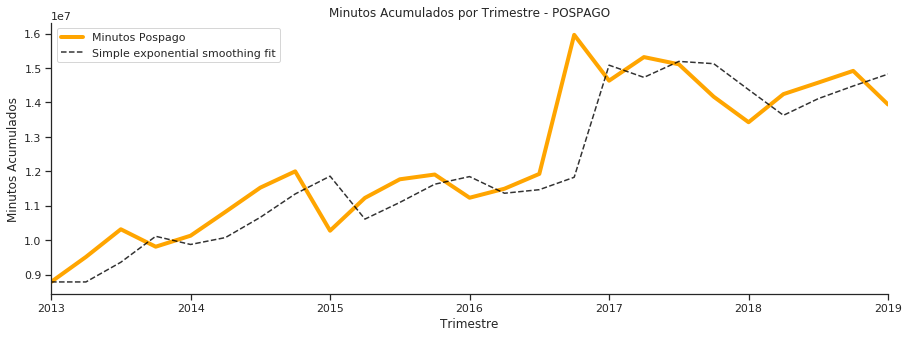

In [39]:
fig, ax= plt.subplots();#figsize=(9,6))
y_pospago.plot(color='orange', label='Minutos Pospago', lw=4)
fitted_pospago.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8,ls='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Minutos Acumulados por Trimestre - POSPAGO')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

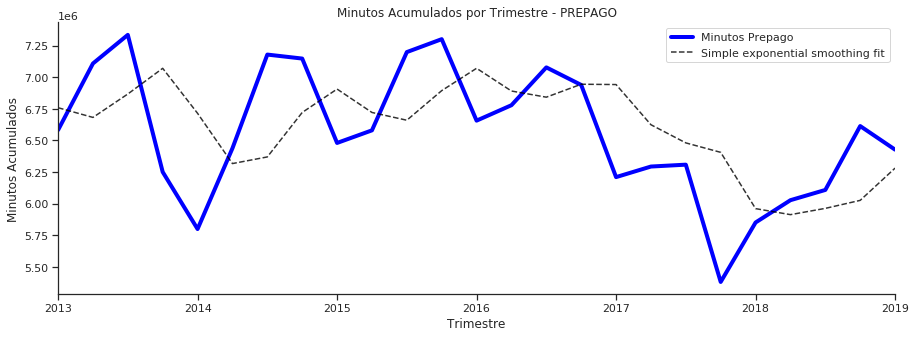

In [38]:
fig, ax= plt.subplots();#figsize=(9,6))
y_prepago.plot(color='blue', label='Minutos Prepago', lw=4)
fitted_prepago.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8,ls='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Minutos Acumulados por Trimestre - PREPAGO')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [40]:
resid_pospago=y_pospago-fitted_pospago # model_ses.resid isn't a panda.Series, so no index, no plot
resid_prepago=y_prepago-fitted_prepago 

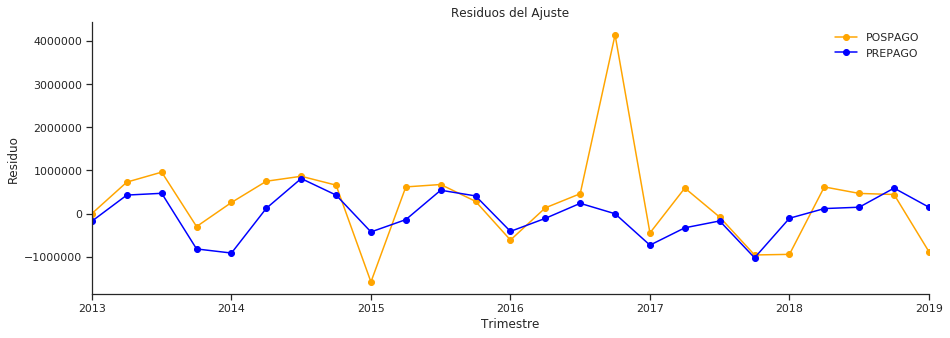

In [53]:
fig, ax= plt.subplots();#figsize=(9,6))
resid_pospago.plot(color='orange',marker='o',label='POSPAGO')
resid_prepago.plot(color='blue',marker='o',label='PREPAGO')
ax.set_xlabel('Trimestre')
ax.set_ylabel('Residuo')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos del Ajuste')
plt.legend(frameon=False)
sns.despine()
plt.show()

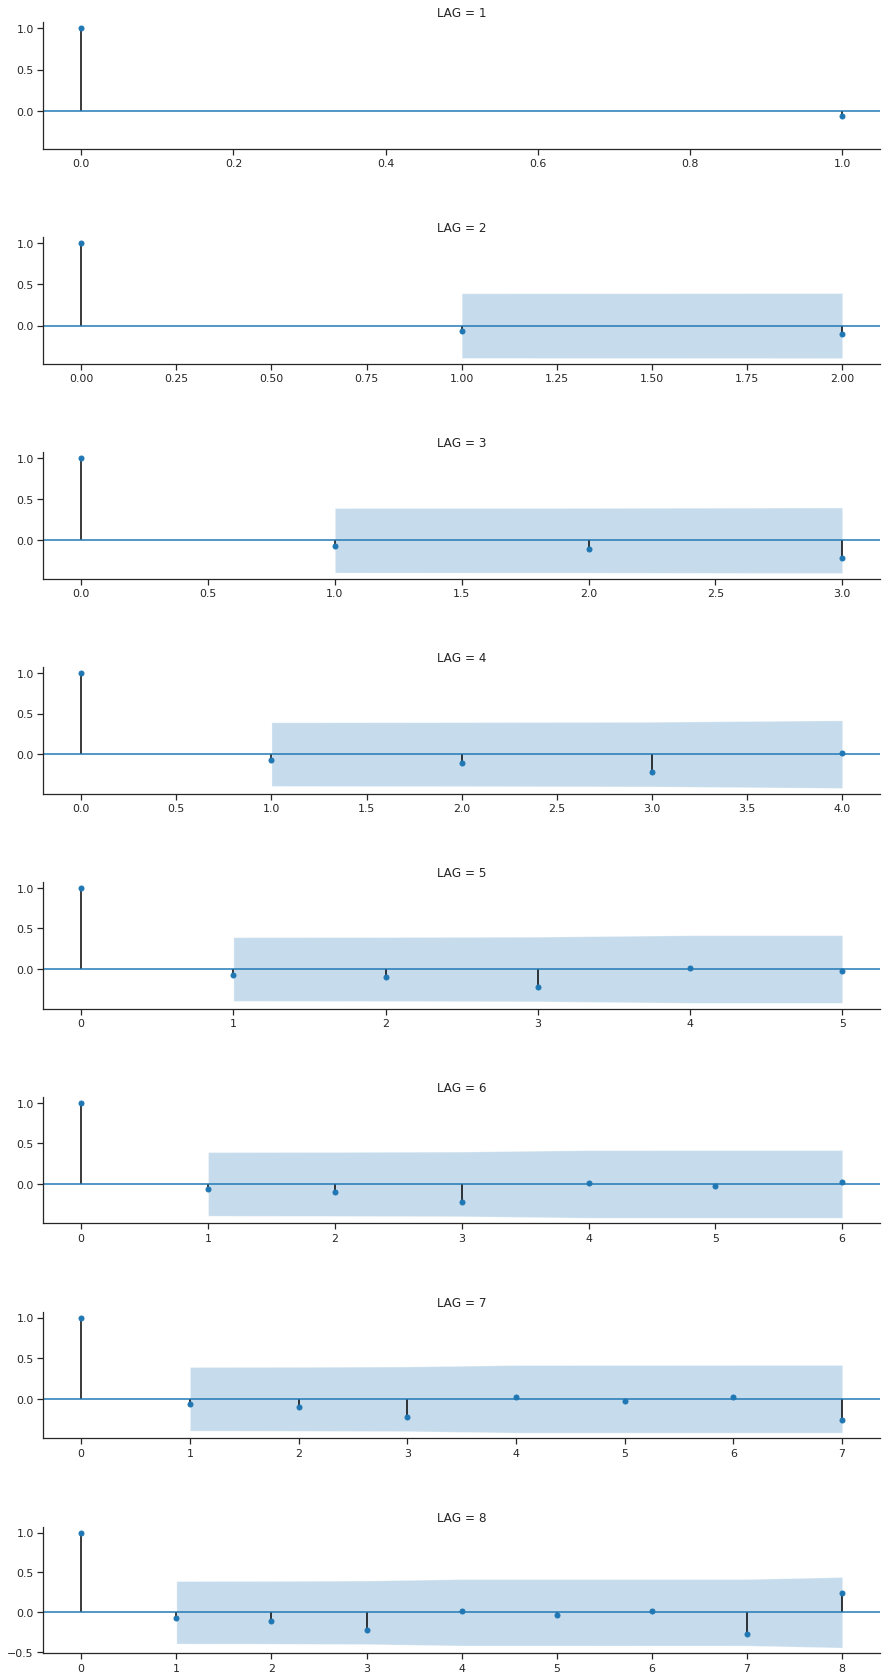

In [69]:
plt.figure(figsize=(15,30))
for i,lag in enumerate([1,2,3,4,5,6,7,8]):
    ax = plt.subplot(8,1,i+1)
    sm.graphics.tsa.plot_acf(resid_pospago, lags=lag , ax=ax)
    plt.title('LAG = '+str(lag))
    sns.despine()
    
plt.subplots_adjust(hspace=0.7)
plt.show()

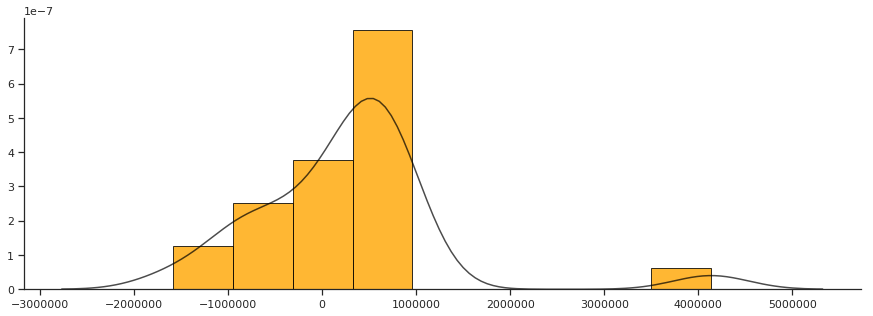

In [72]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'orange'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid_pospago)
plt.show()

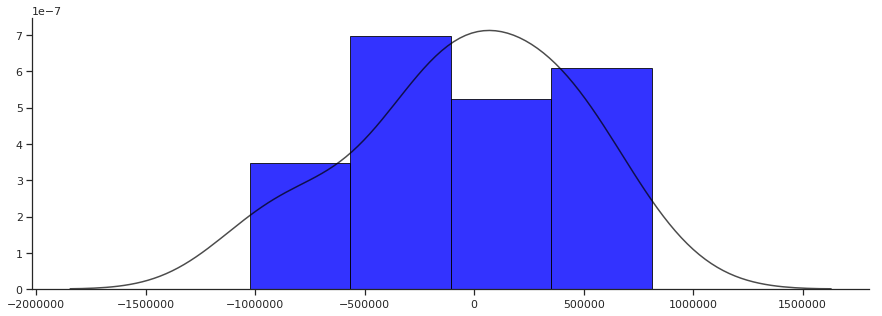

In [74]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'blue'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid_prepago)
plt.show()